1. 파일 불러오기

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kiwipiepy import Kiwi
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf 
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_excel('./data/03.머신러닝_01리뷰분류분석_올리브영_제품_독도.xlsx')
df1 = pd.read_excel('./data/03.머신러닝_01리뷰분류분석_올리브영_제품_리들샷.xlsx')
df = pd.concat([df, df1])
df

,keyword,review
0,무난해요,진짜 제 리뷰 중 절반가까이를 차지하고 있는 꾸준템입니다:-)초초초 민감성에 트러블...
1,보습력이 좋아요,진짜 제 리뷰 중 절반가까이를 차지하고 있는 꾸준템입니다:-)초초초 민감성에 트러블...
2,순해요,로션이 묽은게 좋아서 구입하게 되엇어요원래는 약산성으로된 제품을 찾고잇었는데스킨으로...
3,효과를 모르겠어요,로션이 묽은게 좋아서 구입하게 되엇어요원래는 약산성으로된 제품을 찾고잇었는데스킨으로...
4,성분이 좋아요,로션이 묽은게 좋아서 구입하게 되엇어요원래는 약산성으로된 제품을 찾고잇었는데스킨으로...
...,...,...
139,효과를 모르겠어요,생각했던 것보다 더 따갑고 여드름 흔적에 효과 있다고 해서 샀는데 크게 효과가 없었어요
140,피부결이 개선됐어요,오호 예민한 피부인데 크게 자극없어요진짜 찌르는 느낌나는게 싱기방기 ㅎㅎ이런 느낌 ...
141,무난해요,솔직히 처음에 바를때는 도대체 이게 왜이렇게 난리인걸까? 했는데 어떤 크림이랑 같이...
142,자극적이에요,처음 사용할 때는 바늘이 진짜 피부를 찌르는 것처럼 따끔하더라구요!그렇게 바르고 흡...


2. 전처리

- 결측치 제거

In [5]:
df = df[['keyword','review']]
df = df.dropna()
df.isnull().sum()

keyword    0
review     0
dtype: int64

In [6]:
df['keyword'].value_counts()

keyword
순해요            394
보습력이 좋아요       212
제형이 마음에 들어요    190
무난해요           169
가성비가 좋아요       161
재구매했어요         112
보습이 안 돼요        65
기타              64
자극적이에요          55
패키지가 쓰기 편해요     50
피부결이 개선됐어요      37
유분이 많아요         36
성분이 좋아요         28
진정이 돼요          22
효과를 모르겠어요       22
효과가 좋아요         22
쓰기 불편해요         15
트러블이 줄었어요       10
모공이 줄었어요        10
향이 별로예요          8
탄력이 생겨요          5
트러블이 올라와요        2
붉은 기가 나아졌어요      2
Name: count, dtype: int64

- y값 축소(제거)

In [7]:
drop_keyword = ['진정이 돼요','효과를 모르겠어요','효과가 좋아요','쓰기 불편해요','트러블이 줄었어요','모공이 줄었어요','향이 별로예요','탄력이 생겨요','트러블이 올라와요','붉은 기가 나아졌어요','무난해요','기타']
for keyword in drop_keyword:
    df = df.loc[~df['keyword'].str.contains(keyword)]

In [8]:
df['keyword'].value_counts()

keyword
순해요            394
보습력이 좋아요       212
제형이 마음에 들어요    190
가성비가 좋아요       161
재구매했어요         112
보습이 안 돼요        65
자극적이에요          55
패키지가 쓰기 편해요     50
피부결이 개선됐어요      37
유분이 많아요         36
성분이 좋아요         28
Name: count, dtype: int64

- 한글이 아닌 리뷰 공백으로 교체

In [9]:
df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(df.isnull().sum())
df.shape

keyword    0
review     0
dtype: int64


(1340, 2)

- 한 댓글당 하나의 키워드만 선택

In [10]:
# df_1 = df.drop(df[df['keyword'] == '기타'].index)
df_1 = df.reset_index(drop=True)
df_1 = df_1.drop_duplicates(subset='review')
df_1['keyword'].value_counts()

keyword
순해요            286
보습력이 좋아요       119
제형이 마음에 들어요    115
가성비가 좋아요        94
재구매했어요          85
자극적이에요          47
보습이 안 돼요        41
피부결이 개선됐어요      30
패키지가 쓰기 편해요     25
유분이 많아요         22
성분이 좋아요         13
Name: count, dtype: int64

- 오버 샘플링을 위해 numpy 형태로 변환

In [11]:
np_re = np.array(df_1['review'])
np_key = np.array(df_1['keyword'])
feature = np_re.reshape(-1, 1)
label = np_key.reshape(-1, 1)
print(np_re.shape)
print(np_key.shape)
print(label.shape)
print(df_1['review'].shape)
print(feature)

(877,)
(877,)
(877, 1)
(877,)
[['진짜 제 리뷰 중 절반가까이를 차지하고 있는 꾸준템입니다:-)초초초 민감성에 트러블 피부, 수분 부족형 지성입니다일단 가격이 착해요! 부담없이 사용해볼 수 있다는 장점이 있고, 다른 선택지가 있더라도 독도에 기부할 수 있다는 마음으로 살 수 있는 계기도 좋습니다. 저는 독도 스킨, 토리든 세럼, 독도 로션 2번 이렇게 2년 넘게 꾸준히 사용하고 있습니다. 다른 환경에 영향일 수 도 있지만 저는 이렇게 사용한 후 한번도 심하게 트러블 올라온 적이 없어서 좋았고, 일단 속안까지 수분이 채워지는 느낌이라 항상 애용하고 있습니다!!!진짜 너무너무 강추하고 제발 수분부족형지성은 써봤으면 하는 마음이 큽니다 ㅜㅜ 또한 생각보다 오래써서 한번 사놓고나서 부담이 없다는 것도 큰 장점이라고 생각합니다!']
 ['로션이 묽은게 좋아서 구입하게 되엇어요원래는 약산성으로된 제품을 찾고잇었는데스킨으로 약산성으로 만족하려구요^^이것은 직원분이 잘나가는 제품이라며 추천받고 구매하였습니다가격이 저렴한건지는 모르겠으나 올리브영에서 쇼핑중에 구입 하엿어요사용감은 너무나 좋은데 무엇에 효과가 좋은건지는 잘모르겟어요그래도 만족하며 사용중이에요제품이 성분이 너무나 순해서 만족스러워요다른분들 후기도 너무좋네요~역시 독도라인이 인기가좋은가봐요^^복합성인데 수분이 적당하고 향도 너무 좋아요여드름에도 사용가능해서 트러블이있거나 묽은로션 으로 제격인거같네요']
 ['독도 순면 패드 샀다가 좋아서 독도마스크 사고 독도마스크 샀다가 좋아서 독도로션까지 샀네용ㅋㅋㅋㅋ 이러다가 모든 스킨케어 독도제품으로 바꿀것같아요 이름도 좋아요 독도!!! 우리땅~~ !”!제가 엄청 예민하고 건성인 피부인데 마스크때문에 뒤집어지고 각질일어나는 피부에 쓰기 딱~ 적합한 제품이에요 기획으로 50ml 증정품도 들어있어서 일할때 점심먹고 건조할때 바르기 딱 좋아요 증정품 있는거 넘나 마음에 듭니당... 타 제품 쓰다가 계속 이쪽으로 넘어오네요 ㅋㅋㅋ이 로션 바르고 화장하면 안뜨

3. 오버샘플링

In [12]:
oversample = RandomOverSampler()

# 랜덤오버샘플링
X_over, y_over = oversample.fit_resample(feature, label)

In [13]:
X_over.shape, y_over.shape

((3146, 1), (3146,))

- 오버샘플링한 후, 데이터프레임 형성

In [14]:
df_over = pd.DataFrame({'review': X_over.flatten(), 'keyword': y_over.flatten()})
df_over.to_excel('./learn_data/df_over.xlsx')

In [15]:
df_over['keyword'].value_counts()

keyword
보습력이 좋아요       286
순해요            286
가성비가 좋아요       286
성분이 좋아요        286
패키지가 쓰기 편해요    286
재구매했어요         286
보습이 안 돼요       286
제형이 마음에 들어요    286
피부결이 개선됐어요     286
자극적이에요         286
유분이 많아요        286
Name: count, dtype: int64

In [16]:
len(df_over['keyword'].value_counts())

11

4. 토큰화

In [17]:
kiwi = Kiwi()
def extract_keywords(text):
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if pos[0] in 'NV':
            yield f'{token}'

In [18]:
stopword = ['이','것', '거','저','는']
cv = CountVectorizer(tokenizer=extract_keywords, stop_words=stopword)
dtm_cv = cv.fit_transform(df_over['review'])
trans = TfidfTransformer()
dtm_tfdf = trans.fit_transform(dtm_cv)

C:\Users\SSO\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
words = cv.get_feature_names_out()
words

array(['!꾸덕', '!리치', '!피부', ..., '히터', '힘', '힘들'], dtype=object)

In [20]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names_out(),
    'tf-idf':dtm_tfdf.sum(axis=0).flat
})

wc.sort_values('tf-idf', ascending=False).head(30)

,단어,tf-idf
1708,좋,288.230579
1187,쓰,257.774374
604,로션,219.265860
987,사용,212.895910
1557,있,195.979783
811,바르,188.622699
2070,피부,181.640125
61,같,175.860224
2088,하,173.360824
873,보,155.888680


In [21]:
len(words)

2213

5. 인코딩(y:레이블인코딩-원핫인코딩)

- 레이블인코딩

In [22]:
e = LabelEncoder()
y_label = e.fit_transform(df_over['keyword'])

print(y_label)

[ 1  4  1 ... 10 10 10]


- 레이블디코딩 위한 데이터프레임 형성

In [23]:
df_label = pd.DataFrame({
    'keyword':df_over['keyword'], 'label': y_label
})
df_label.head()
df_label['keyword'].loc[df_label['label']==1][0]

'보습력이 좋아요'

- 원핫인코딩

In [24]:
def vectorize_sequences(sequences, dimention):
    result = np.zeros((len(sequences), dimention))

    for i, sequence in enumerate(sequences):
        result[i, sequence] = 1.

    return result


In [25]:
y = vectorize_sequences(y_label, dimention =11).astype('float32')


- 딥러닝을 위해 numpy 형식으로 변환

In [26]:
y = np.array(y)
x = np.array(dtm_cv.A)
print(y.shape)
print(x.shape)

(3146, 11)
(3146, 2213)


6. 인공신경망 학습

- KFold / splits=3 / optimizer = adam / batch_size=64 / epochs=20

In [27]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(x)
model_accuracy = []
for train_index, test_index in kf.split(x):
   

   x_train, x_test = x[train_index], x[test_index]
   y_train, y_test = y[train_index], y[test_index]

   # 모델 학습
   history = model.fit(x_train, y_train, epochs=20,batch_size=64, validation_split=0.2)
   loss, accuracy = model.evaluate(x_test, y_test)
   pred = model.predict(x_test)
   pred_classes = np.argmax(pred, axis=1)
   print(f'Fold 평가 - Loss: {loss}, Accuracy: {accuracy}')



Epoch 1/20

27/27 [==============================] - 2s 44ms/step - loss: 2.2679 - accuracy: 0.2952 - val_loss: 2.9611 - val_accuracy: 0.0143
Epoch 2/20
27/27 [==============================] - 1s 41ms/step - loss: 1.8233 - accuracy: 0.6047 - val_loss: 3.7069 - val_accuracy: 0.0286
Epoch 3/20
27/27 [==============================] - 1s 42ms/step - loss: 1.3519 - accuracy: 0.7400 - val_loss: 4.2559 - val_accuracy: 0.0762
Epoch 4/20
27/27 [==============================] - 1s 43ms/step - loss: 0.9917 - accuracy: 0.8247 - val_loss: 4.0359 - val_accuracy: 0.0857
Epoch 5/20
27/27 [==============================] - 1s 43ms/step - loss: 0.7313 - accuracy: 0.8790 - val_loss: 3.5658 - val_accuracy: 0.0976
Epoch 6/20
27/27 [==============================] - 1s 44ms/step - loss: 0.5432 - accuracy: 0.9052 - val_loss: 2.7108 - val_accuracy: 0.1857
Epoch 7/20
27/27 [==============================] - 1s 43ms/step - loss: 0.4058 - accuracy: 0.9338 - val_loss: 2.2825 - val_accuracy: 0.2762
Epoch 8/20

- KFold / splits=3 / optimizer = rmsprop / batch_size=64 / epochs=20

In [95]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(x)
model_accuracy = []
for train_index, test_index in kf.split(x):
   
   # print("TRAIN:", train_index, "TEST:", test_index)
   x_train, x_test = x[train_index], x[test_index]
   y_train, y_test = y[train_index], y[test_index]

   # 모델 학습
   history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
   loss, accuracy = model.evaluate(x_test, y_test)
   pred = model.predict(x_test)
   pred_classes = np.argmax(pred, axis=1)
   print(f'Fold 평가 - Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/20
27/27 [==============================] - 1s 39ms/step - loss: 2.3428 - accuracy: 0.2874 - val_loss: 2.6725 - val_accuracy: 0.0000e+00
Epoch 2/20
27/27 [==============================] - 1s 43ms/step - loss: 2.1736 - accuracy: 0.5122 - val_loss: 3.0890 - val_accuracy: 0.0000e+00
Epoch 3/20
27/27 [==============================] - 1s 39ms/step - loss: 1.9357 - accuracy: 0.5874 - val_loss: 3.4273 - val_accuracy: 0.0000e+00
Epoch 4/20
27/27 [==============================] - 1s 35ms/step - loss: 1.6647 - accuracy: 0.6691 - val_loss: 3.6253 - val_accuracy: 0.0000e+00
Epoch 5/20
27/27 [==============================] - 1s 39ms/step - loss: 1.3954 - accuracy: 0.7436 - val_loss: 3.7304 - val_accuracy: 0.0000e+00
Epoch 6/20
27/27 [==============================] - 1s 37ms/step - loss: 1.1519 - accuracy: 0.7764 - val_loss: 3.8358 - val_accuracy: 0.0000e+00
Epoch 7/20
27/27 [==============================] - 1s 30ms/step - loss: 0.9437 - accuracy: 0.8229 - val_loss: 3.8361 - val_accura

- 밸리데이션 평가

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

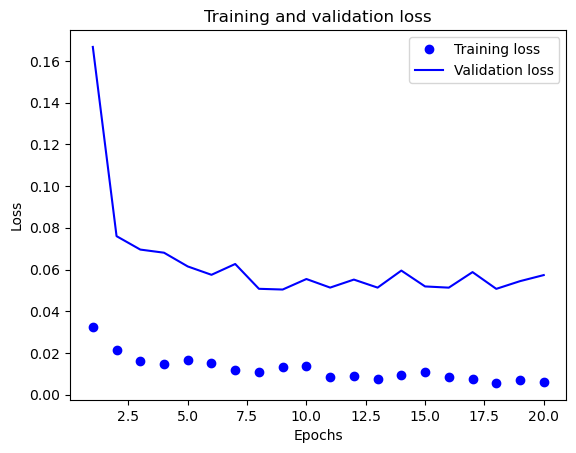

In [40]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

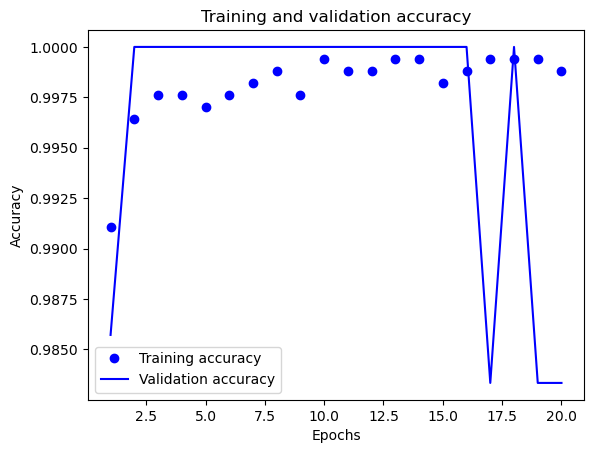

In [41]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 인공신경망 재설정(epochs=7)

In [46]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(x)

for train_index, test_index in kf.split(x):
   x_train, x_test = x[train_index], x[test_index]
   y_train, y_test = y[train_index], y[test_index]

   # 모델 학습
   history = model.fit(x_train, y_train, epochs=7,batch_size=64, validation_split=0.2)
   loss, accuracy = model.evaluate(x_test, y_test)
   pred = model.predict(x_test)
   y_pred=np.argmax(pred, axis=1)
   y_test=np.argmax(y_test, axis=1) 
   cm = confusion_matrix(y_test, y_pred)
print(f'Fold 평가 - Loss: {loss}, Accuracy: {accuracy}')
print(cm)

Epoch 1/7
27/27 [==============================] - 1s 51ms/step - loss: 2.2705 - accuracy: 0.2654 - val_loss: 2.8946 - val_accuracy: 0.0048
Epoch 2/7
27/27 [==============================] - 1s 55ms/step - loss: 1.9021 - accuracy: 0.5289 - val_loss: 3.2285 - val_accuracy: 0.0167
Epoch 3/7
27/27 [==============================] - 1s 44ms/step - loss: 1.4610 - accuracy: 0.7335 - val_loss: 3.4700 - val_accuracy: 0.0524
Epoch 4/7
27/27 [==============================] - 1s 42ms/step - loss: 1.0773 - accuracy: 0.8038 - val_loss: 3.4899 - val_accuracy: 0.0667
Epoch 5/7
27/27 [==============================] - 1s 41ms/step - loss: 0.7814 - accuracy: 0.8646 - val_loss: 3.1168 - val_accuracy: 0.1571
Epoch 6/7
27/27 [==============================] - 1s 52ms/step - loss: 0.5575 - accuracy: 0.9022 - val_loss: 2.4643 - val_accuracy: 0.2476
Epoch 7/7
33/33 [==============================] - 0s 6ms/step
Epoch 1/7
27/27 [==============================] - 1s 45ms/step - loss: 0.4224 - accuracy: 0.9106

In [49]:
print(cm)
print(classification_report(y_test, y_pred))

[[ 93   0   0   0   0   0   0   0   0   0   0]
 [  1  95   0   0   0   0   0   0   0   0   0]
 [  0   0  87   0   0   0   0   0   0   0   0]
 [  0   0   0 109   0   0   0   0   0   0   0]
 [  1   1   0   0 108   0   0   0   0   0   0]
 [  0   0   0   0   0  88   0   0   0   0   0]
 [  0   0   0   0   0   0  97   0   0   0   0]
 [  0   0   0   0   3   0   0  83   1   0   0]
 [  3   1   0   0   1   0   0   0  85   2   0]
 [  0   0   0   0   6   0   0   0   0  91   0]
 [  0   3   0   0   0   0   0  10   0   0  79]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        93
           1       0.95      0.99      0.97        96
           2       1.00      1.00      1.00        87
           3       1.00      1.00      1.00       109
           4       0.92      0.98      0.95       110
           5       1.00      1.00      1.00        88
           6       1.00      1.00      1.00        97
           7       0.89      0.95      0.92      

7. 예측

In [33]:
specific_review = '저는 건성인데 건조해요'
specific_review = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", specific_review)
specific_review_transformed = cv.transform([specific_review])
specific_review_trans = trans.transform(specific_review_transformed)
prediction = model.predict(specific_review_transformed.A)
prediction


1/1 [==============================] - 0s 40ms/step


array([[2.82458233e-04, 6.03191368e-03, 9.86410916e-01, 1.08735156e-04,
        4.35037888e-04, 1.89310056e-04, 1.40081087e-04, 2.94092437e-03,
        2.89935293e-03, 5.26253789e-05, 5.08688216e-04]], dtype=float32)

In [34]:
for i in range(len(prediction)):
    predicted_label_index = np.argmax(prediction[i])  # 예측된 라벨의 인덱스
    actual_label_index = np.argmax(y_test[i])         # 실제 라벨의 인덱스

    predicted_label = df_label.loc[df_label['label'] == predicted_label_index, 'keyword'].iloc[0]  # 예측된 라벨 디코딩
    actual_label = df_label.loc[df_label['label'] == actual_label_index, 'keyword'].iloc[0]       # 실제 라벨 디코딩

    print(f"예측된 라벨: {predicted_label}, 실제 라벨: {actual_label}")

예측된 라벨: 보습이 안 돼요, 실제 라벨: 보습력이 좋아요


In [35]:
top3_predicted_indices = np.argsort(prediction[i])[::-1][:3]

for j, index in enumerate(top3_predicted_indices):
    predicted_label_index = index  # 예측된 레이블의 인덱스
    predicted_label = df_label.loc[df_label['label'] == predicted_label_index, 'keyword'].iloc[0]  # 예측된 레이블 가져오기
    probability = prediction[i][index]               # 해당 클래스의 확률
    print(f"상위 {j+1}: {predicted_label} (확률: {probability:.2f})")

상위 1: 보습이 안 돼요 (확률: 0.99)
상위 2: 보습력이 좋아요 (확률: 0.01)
상위 3: 재구매했어요 (확률: 0.00)


In [36]:
predicted_indices = np.argsort(prediction[i])[::-1]

for j, index in enumerate(predicted_indices):
    predicted_label_index = index  # 예측된 레이블의 인덱스
    predicted_label = df_label.loc[df_label['label'] == predicted_label_index, 'keyword'].iloc[0]  # 예측된 레이블 가져오기
    probability = prediction[i][index]               # 해당 클래스의 확률
    print(f"상위 {j+1}: {predicted_label} (확률: {probability:.2f})")

상위 1: 보습이 안 돼요 (확률: 0.99)
상위 2: 보습력이 좋아요 (확률: 0.01)
상위 3: 재구매했어요 (확률: 0.00)
상위 4: 제형이 마음에 들어요 (확률: 0.00)
상위 5: 피부결이 개선됐어요 (확률: 0.00)
상위 6: 순해요 (확률: 0.00)
상위 7: 가성비가 좋아요 (확률: 0.00)
상위 8: 유분이 많아요 (확률: 0.00)
상위 9: 자극적이에요 (확률: 0.00)
상위 10: 성분이 좋아요 (확률: 0.00)
상위 11: 패키지가 쓰기 편해요 (확률: 0.00)


In [51]:
predicted_indices = np.argsort(prediction[i])[::-1]

for j, index in enumerate(predicted_indices):
    predicted_label_index = index 
    predicted_label = df_label.loc[df_label['label'] == predicted_label_index, 'keyword'].iloc[0] 
    probability = prediction[i][index]
    if probability >= 0.3:
        print(predicted_label)
    else:
        pass

보습이 안 돼요
